# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#Загрузка библиотек:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
import timeit
warnings.filterwarnings("ignore")

In [2]:
#Загрузка и исследование файла с данными:
auto = pd.read_csv('/datasets/autos.csv')
auto.sample(n = 10, random_state = 12345)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46
63295,2016-03-07 12:55:48,11000,wagon,2010,auto,177,5er,150000,10,gasoline,bmw,no,2016-03-07 00:00:00,0,6237,2016-04-04 02:16:33
299143,2016-03-24 17:48:59,1200,small,2003,NaN,58,clio,150000,3,petrol,renault,no,2016-03-24 00:00:00,0,25551,2016-03-24 17:48:59
236634,2016-03-27 09:57:43,12500,convertible,1977,auto,177,sl,150000,5,petrol,mercedes_benz,no,2016-03-27 00:00:00,0,53177,2016-03-27 10:38:40
44603,2016-04-02 18:38:59,1599,NaN,2016,manual,50,arosa,125000,10,NaN,seat,no,2016-04-02 00:00:00,0,2991,2016-04-06 18:16:10
251416,2016-03-20 23:53:52,1999,small,2002,manual,75,corsa,150000,1,petrol,opel,NaN,2016-03-20 00:00:00,0,46537,2016-03-21 04:41:29


In [3]:
auto.shape

(354369, 16)

**Выводы:** 
- В датафрейме **354369** объектов, имеющих **16** признаков, из которых **9**  количественных *("DateCrawled", "Price", "RegistrationYear", "Power", "Kilometer", "RegistrationMonth", "DateCreated", "NumberOfPictures", "LastSeen"*) и  **7** категориальных *("VehicleType", "Gearbox", "Model", "FuelType", "Brand2, "NotRepaired", "PostalCode"*). Целевой признак - **"Price"**. 
- Сразу исключаем следующие признаки: **"DateCrawled"** - дата скачивания анкеты из базы не имеет отношения к формированию цены; **"LastSeen"** - дата последней активности пользователя также не влияет на ценообразование; **"RegistrationMonth"** - на сайтах по продаже автомобилей указывается только год регистрации, соответственно, данный признак уже избыточный.

In [4]:
auto1 = auto.drop(['DateCrawled','RegistrationMonth','LastSeen'], axis = 1)

In [5]:
#Анализ исходных данных:
def analiz(data):
    svod = []
    for i in range(len(data.columns)):
        prop = round(data[data.columns[i]].isna().mean() *100, 2)
        null = round(len(data[data[data.columns[i]] == 0]) / len(data) * 100, 2)
        mini = pd.to_numeric(data[data.columns[i]], errors ='coerce').min()
        maxi = pd.to_numeric(data[data.columns[i]], errors ='coerce').max()
        svod.append([prop, null, mini, maxi])
    index = data.columns
    columns = ['Пропуски, %','0-е значения, %','Минимум','Максимум']
    svod_tab = pd.DataFrame(svod, index=index, columns=columns).sort_values(by = 'Пропуски, %', ascending = False)
    dubl = data.duplicated().sum()
    print('1. Дубликаты в данных:', round(dubl/len(data)*100,2),'%')
    print('2. Сводная таблица по признакам:')
    return svod_tab
analiz(auto1)

1. Дубликаты в данных: 3.05 %
2. Сводная таблица по признакам:


,"Пропуски, %","0-е значения, %",Минимум,Максимум
NotRepaired,20.08,0.00,NaN,NaN
VehicleType,10.58,0.00,NaN,NaN
FuelType,9.28,0.00,NaN,NaN
Gearbox,5.60,0.00,NaN,NaN
Model,5.56,0.00,80.0,9000.0
Price,0.00,3.04,0.0,20000.0
RegistrationYear,0.00,0.00,1000.0,9999.0
Power,0.00,11.35,0.0,20000.0
Kilometer,0.00,0.00,5000.0,150000.0
Brand,0.00,0.00,NaN,NaN


**Выводы:**
- Имеем *3.05%* дубликатов в данных (вероятно, пользователи выкладывали анкеты несколько раз). Решение: удаляем данные с целью облегчения обучения моделей;
- Имеем пропуски по *5-ти* признакам: **"NotRepaired"** - *20.08%* - вероятно, пользователи умышленно не указывали данные по признаку, так как он существенно влияет на цену. **Решение:** заполняем пропуски новой категорией **"not_specified"**; **"VehicleType"** - *10.58%* - вероятно, пропуски связаны со сложностями в определении пользователями типов кузовов собственных машин. **Решение:** заполняем пропуски новой категорией **"not_specified"**; **"FuelType"** - *9.28%* - аналогично с **"VehicleType"**; **"Gearbox"** - *5.6%* - вероятно, пользователи умышленно не указывали данные по виду коробки передач, так как он влияет на конечную цену (иногда существенно). **Решение:** заполняем пропуски новой категорией **"not_specified"**; **"Model"** - *5.56%* - вероятно, пользователи умышленно не указывали данные по признаку, так как он влияет на конечную цену (иногда существенно). **Решение:** заполняем пропуски новой категорией **"not_specified"**;
- Имеем 0-ые значения по *2-м* признакам: **"Price"** - цена не может быть 0-й. **Решение:** убираем значения меньше 100;  **"NumberOfPictures"** - вероятно, ошибка выгрузки привела ко всем 0-м. **Решение** исключаем признак из анализа.
- Имеем аномальные значения по минимуму и/или максимуму по *2-м признакам*: **"RegistrationYear"**. **Решение:** исключаем все значения вне диапазона *1920 - 2016г.*; **"Power"** - мощность двигателя не может быть равна 0 л.с. и быть больше 750 л.с..**Решение:** исключаем все значения вне диапазона *0.75 (окей, гугл) - 750 л.с.*;
- **"PostalCode"** имеет много уникальных значений.**Решение:** создаём новый признак из PostalCode (делим значения признака на 1000 и затем округляем до целых чисел, в итоге получая номера регионов).

**Рекомендации для разработчиков:** 
- сделать обязательными для заполнения поля признаков **"NotRepaired", "VehicleType", "FuelType", "Gearbox", "Model"**;
- установить диапазоны для выбора значений для признаков **"RegistrationYear", "Power"**, **"Price"**;
- ввести новый признак **PostalCode**;
- проверить механизм выгрузки данных из базы.

**Реализация решений:**

In [6]:
change_lists = ['NotRepaired','VehicleType','FuelType','Gearbox','Model']
def change(lists):
    for i in range(len(lists)):
        auto1[lists[i]].fillna('not_specified', inplace = True)
        
change(change_lists)        

In [7]:
auto3 = auto1.query('1920 <= RegistrationYear <= 2016 and 0.75 <= Power <= 750 and Price >= 100')
auto3['PostalCode'] = (auto3['PostalCode']/1000).astype(int)
auto5 = auto3.drop(['NumberOfPictures','PostalCode', 'DateCreated'], axis = 1)
auto6 = auto5.drop_duplicates()
auto7 = auto5.drop_duplicates()

In [8]:
analiz(auto7)

1. Дубликаты в данных: 0.0 %
2. Сводная таблица по признакам:


,"Пропуски, %","0-е значения, %",Минимум,Максимум
Price,0.0,0.0,100.0,20000.0
VehicleType,0.0,0.0,NaN,NaN
RegistrationYear,0.0,0.0,1923.0,2016.0
Gearbox,0.0,0.0,NaN,NaN
Power,0.0,0.0,1.0,750.0
Model,0.0,0.0,80.0,9000.0
Kilometer,0.0,0.0,5000.0,150000.0
FuelType,0.0,0.0,NaN,NaN
Brand,0.0,0.0,NaN,NaN
NotRepaired,0.0,0.0,NaN,NaN


In [9]:
auto7.sample(n = 10, random_state = 12345)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
66628,1800,wagon,1993,manual,116,other,150000,petrol,volvo,no
190122,500,coupe,1999,manual,127,other,125000,petrol,ford,yes
259618,2650,small,2003,manual,62,polo,125000,petrol,volkswagen,not_specified
46533,299,small,2001,manual,75,fiesta,5000,not_specified,ford,no
237675,1550,sedan,2001,manual,105,golf,150000,petrol,volkswagen,no
76322,1350,sedan,2000,manual,105,3er,150000,petrol,bmw,no
327047,3800,sedan,2002,auto,131,a4,150000,petrol,audi,no
189546,1990,sedan,1999,manual,105,3er,100000,petrol,bmw,yes
112843,280,small,1995,manual,75,golf,150000,petrol,volkswagen,not_specified
243226,2350,small,1999,manual,131,punto,150000,petrol,fiat,no


Для корректной работы алгоритмов выполним кодирование категориальных перменных. Чтобы не увеличивать количество столбцов, воспользуемся техникой порядкового кодирования:

In [10]:
encoder_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()
encoder.fit(auto7[encoder_columns])
auto7[encoder_columns] = encoder.transform(auto7[encoder_columns])
auto7.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,161.0,125000,2.0,1.0,2.0
2,9800,7.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0
3,1500,6.0,2001,1.0,75,116.0,150000,7.0,38.0,0.0
4,3600,6.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
5,650,5.0,1995,1.0,102,11.0,150000,7.0,2.0,2.0


Рассмотрим корреляцию между признаками:

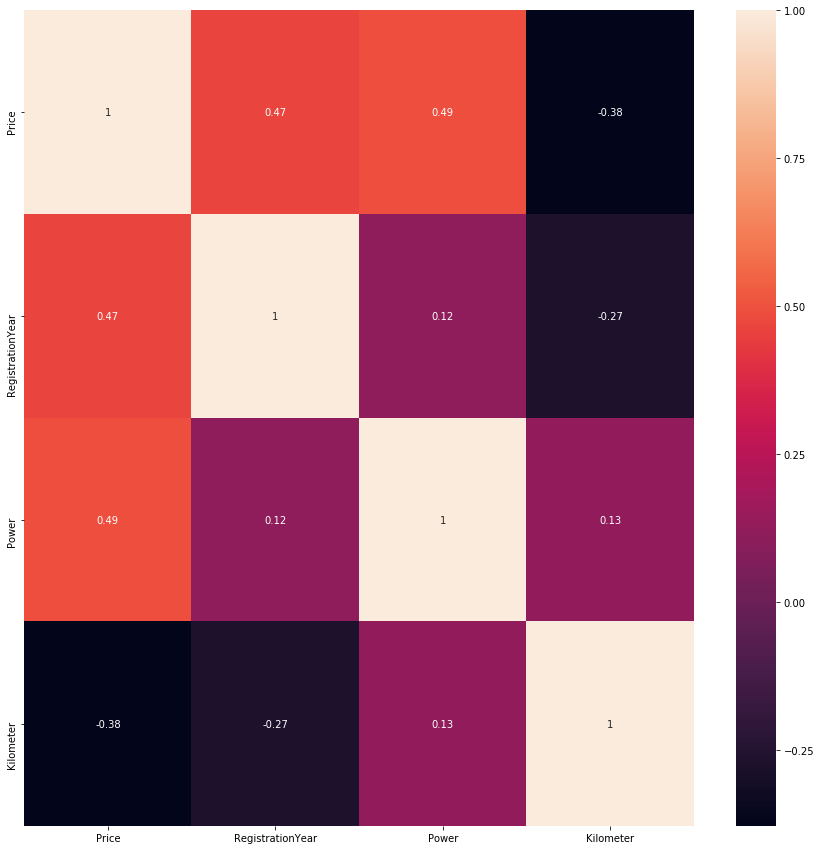

In [11]:

correlation_mat = auto7.drop(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], axis = 1).corr()
plt.subplots(figsize=(15,15)) 
sns.heatmap(correlation_mat, annot = True)
plt.show()

**Вывод:** видим, что влияниие на целевой признак **"Price"** имеют следующие признаки: **"RegistrationYear"** - 0.48 (чем новее автомобиль, тем дороже), **"Power"** - 0.5 (чем мощнее двигатель, тем выше цена), **"Kilometer"** - (-0.39) (чем больше пробег, тем ниже цена).

**Итог:** Данные подготовлены для обучения моделей.

## Обучение моделей

Обучим следующие модели: 
- **CatBoost;**
- **LightGBM;** 
- **решающее дерево;**
- **случайный лес**. 

Основная метрика качества моделей: **метрика RMSE**.

### Формирование выборок

Разделим основной датасет на три выборки - тренировочную, валидационную и тестовую в соотношении **3:1:1**

In [12]:
features_list = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 
                 'Kilometer', 'FuelType', 'Brand', 'NotRepaired']

target_list = ['Price']

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

features_train, features_valid, target_train, target_valid = \
train_test_split(auto7[features_list], auto7[target_list], test_size=0.4, random_state = 12345)

features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size = 0.5, random_state = 12345)

ct_features_train, ct_features_valid, ct_target_train, ct_target_valid = \
train_test_split(auto6[features_list], auto6[target_list], test_size=0.4, random_state = 12345)

ct_features_valid, ct_features_test, ct_target_valid, ct_target_test = \
train_test_split(ct_features_valid, ct_target_valid, test_size = 0.5, random_state = 12345)

In [13]:
print(len(auto7))
len(features_train) + len(features_valid) + len(features_test)

256391


256391

Выборки готовы.

### Catboost

In [14]:
%%time
start_time = timeit.default_timer()
cb_model = CatBoostRegressor(learning_rate = 0.4,
                             early_stopping_rounds = 20, 
                             random_state = 12345, 
                             one_hot_max_size = 300)
cb_model.fit(ct_features_train, ct_target_train, cat_features = cat_features, 
               eval_set = (ct_features_valid, ct_target_valid), verbose = 100)
cb_train_time = timeit.default_timer() - start_time

0:	learn: 3547.6450737	test: 3536.9015403	best: 3536.9015403 (0)	total: 65.2ms	remaining: 1m 5s
100:	learn: 1628.1775163	test: 1680.7720059	best: 1680.7720059 (100)	total: 9.69s	remaining: 1m 26s
200:	learn: 1551.2772901	test: 1637.3042412	best: 1637.3042412 (200)	total: 19.3s	remaining: 1m 16s
300:	learn: 1507.0051910	test: 1615.7977315	best: 1615.7977315 (300)	total: 28.7s	remaining: 1m 6s
400:	learn: 1474.5535823	test: 1606.3443134	best: 1606.3443134 (400)	total: 38.3s	remaining: 57.1s
500:	learn: 1449.0876642	test: 1600.5824034	best: 1600.5824034 (500)	total: 48s	remaining: 47.8s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 1599.031551
bestIteration = 573

Shrink model to first 574 iterations.
CPU times: user 50.3 s, sys: 7.44 s, total: 57.7 s
Wall time: 59.3 s


In [15]:
cb_model.best_score_

{'learn': {'RMSE': 1429.2634385846945},
 'validation': {'RMSE': 1599.0315512974119}}

In [16]:
cb_train_score = cb_model.best_score_['learn']['RMSE']
cb_valid_score = cb_model.best_score_['validation']['RMSE']

In [17]:
%%time
start_time = timeit.default_timer()
cb_test_result = cb_model.predict(ct_features_test)
cb_predict_time = timeit.default_timer() - start_time

CPU times: user 159 ms, sys: 11.7 ms, total: 171 ms
Wall time: 99.3 ms


In [18]:
cb_test_score = mean_squared_error(ct_target_test, cb_test_result) ** 0.5
cb_test_score

1596.2787041956976

### LightGBM

Чтобы у двух рассмотренных моделей был общий знаменатель для сравнения, максимальное количество деревьев установим 670 и скорость обучения подберём по аналогии с Catboost, чтобы задача сошлась ближе к концу. 

In [19]:
%%time
start_time = timeit.default_timer()
lgbm_model = LGBMRegressor(max_depth=5, 
                            n_estimators = 100, 
                            random_state = 12345, 
                            objective='regression',
                            num_leaves = 70,
                            metric = 'rmse')
lgbm_model.fit(features_train, target_train, categorical_feature = cat_features, verbose = 100)
predictions_valid = lgbm_model.predict(features_valid, num_iteration=2)
print(mean_squared_error(predictions_valid, target_valid) ** 0.5)
lgbm_train_time = timeit.default_timer() - start_time

4015.843201347629
CPU times: user 4min 1s, sys: 1.72 s, total: 4min 3s
Wall time: 4min 6s


In [20]:
lgbm_train_score = mean_squared_error(target_train, lgbm_model.predict(features_train)) ** 0.5
lgbm_valid_score = mean_squared_error(target_valid, lgbm_model.predict(features_valid)) ** 0.5

In [21]:
%%time
start_time = timeit.default_timer()
lgbm_test_result = lgbm_model.predict(features_test)
lgbm_predict_time = timeit.default_timer() - start_time

CPU times: user 458 ms, sys: 0 ns, total: 458 ms
Wall time: 460 ms


In [22]:
lgbm_test_score = mean_squared_error(target_test, lgbm_test_result) ** 0.5
lgbm_test_score

1667.6757801364643

### Решающее дерево

Для корректной работы алгоритмов выполним кодирование категориальных перменных. Чтобы не увеличивать количество столбцов, воспользуемся техникой порядкового кодирования:

In [23]:
encoder_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()
encoder.fit(auto7[encoder_columns])
auto7[encoder_columns] = encoder.transform(auto7[encoder_columns])
auto7.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,2.0,2011,1.0,190,161.0,125000,2.0,1.0,2.0
2,9800,7.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0
3,1500,6.0,2001,1.0,75,116.0,150000,7.0,38.0,0.0
4,3600,6.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
5,650,5.0,1995,1.0,102,11.0,150000,7.0,2.0,2.0


In [24]:
model = DecisionTreeRegressor(random_state=42)

tree_params = {
    'max_depth':[x for x in range(1, 50, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

tree_grid = RandomizedSearchCV(model, tree_params, 
                               scoring = 'neg_mean_squared_error', 
                               n_iter = 20, random_state = 12345, cv = 5)
tree_grid.fit(features_train, target_train)

tree_model = DecisionTreeRegressor(random_state = 123454, **tree_grid.best_params_)

In [25]:
%%time
start_time = timeit.default_timer()
tree_model.fit(features_train, target_train)
tree_train_time = timeit.default_timer() - start_time

CPU times: user 443 ms, sys: 0 ns, total: 443 ms
Wall time: 454 ms


In [26]:
%%time
start_time = timeit.default_timer()
tree_test_result = tree_model.predict(features_test)
tree_predict_time = timeit.default_timer() - start_time

CPU times: user 16.7 ms, sys: 0 ns, total: 16.7 ms
Wall time: 22.9 ms


In [27]:
def RMSE(model):
    train_score = mean_squared_error(target_train, model.predict(features_train)) ** 0.5
    valid_score = mean_squared_error(target_valid, model.predict(features_valid)) ** 0.5
    test_score = mean_squared_error(target_test, model.predict(features_test)) ** 0.5
    print('train RMSE =', train_score)
    print('valid RMSE =', valid_score)
    print('test RMSE =', test_score)
    return train_score, valid_score, test_score
tree_train_score, tree_valid_score, tree_test_score = RMSE(tree_model)

train RMSE = 1467.2451944469178
valid RMSE = 1838.1333392814847
test RMSE = 1852.186477463492


### Случайный лес

In [28]:
%time
model = RandomForestRegressor(random_state=42)

#Сетка поиска сокращена для экономии времени
forest_params = {
    'n_estimators':[x for x in range(50, 51, 1)],
    'max_depth':[x for x in range(18, 19, 1)], 
    'min_samples_leaf':[x for x in range(5, 6, 1)],
    'min_samples_split':[x for x in range(3, 4, 1)],
}

forest_grid = RandomizedSearchCV(model, forest_params, 
                                 scoring = 'neg_mean_squared_error', 
                                 n_iter = 1, random_state = 12345, cv = 5)
forest_grid.fit(features_train, np.ravel(target_train))

forest_model = RandomForestRegressor(random_state = 12345, **forest_grid.best_params_)
forest_train_time = timeit.default_timer() - start_time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [29]:
%%time
start_time = timeit.default_timer()
forest_model.fit(features_train, np.ravel(target_train))
forest_train_time = timeit.default_timer() - start_time

CPU times: user 14.5 s, sys: 0 ns, total: 14.5 s
Wall time: 14.8 s


In [30]:
%%time
start_time = timeit.default_timer()
tree_test_result = tree_model.predict(features_test)
forest_predict_time = timeit.default_timer() - start_time

CPU times: user 15.9 ms, sys: 0 ns, total: 15.9 ms
Wall time: 26 ms


In [31]:
forest_train_score, forest_valid_score, forest_test_score = RMSE(forest_model)

train RMSE = 1384.1449304850503
valid RMSE = 1673.6596498856861
test RMSE = 1677.89931670078


## Анализ моделей

In [32]:
data = [
    [cb_train_score, cb_valid_score, cb_test_score, cb_train_time, cb_predict_time],
    [lgbm_train_score, lgbm_valid_score, lgbm_test_score, lgbm_train_time, lgbm_predict_time],
    [forest_train_score, forest_valid_score, forest_test_score, forest_train_time, forest_predict_time],
    [tree_train_score, tree_valid_score, tree_test_score, tree_train_time, tree_predict_time]
       ]
     
index = ['Catboost','LightGBM', 'RandomForest', 'RandomTree']
columns = ['Train_RMSE', 'Valid_RMSE', 'Test_RMSE', 'Train_Time[s]', 'Predict_Time[s]']
final = pd.DataFrame(data, index = index, columns = columns)
final

,Train_RMSE,Valid_RMSE,Test_RMSE,Train_Time[s],Predict_Time[s]
Catboost,1429.263439,1599.031551,1596.278704,59.294935,0.099213
LightGBM,1598.261570,1660.750180,1667.675780,246.059854,0.460233
RandomForest,1384.144930,1673.659650,1677.899317,14.764558,0.025997
RandomTree,1467.245194,1838.133339,1852.186477,0.453611,0.022901


Оценим качество предсказаний моделей:

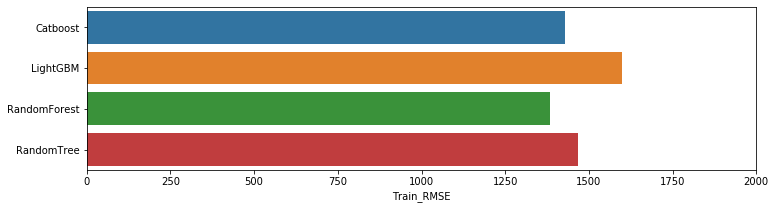

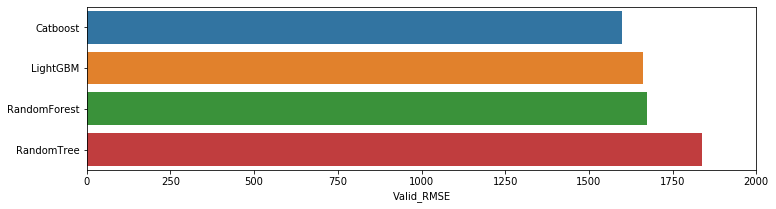

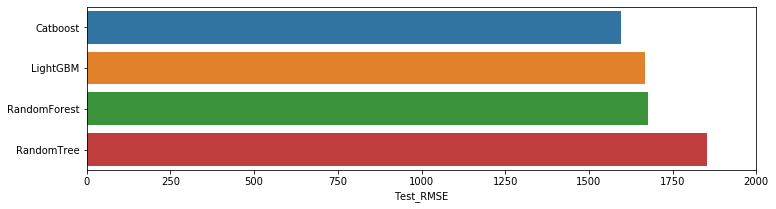

In [33]:
for col in columns[:3]:
    plt.figure(figsize = (12, 3))
    sns.barplot(y = index, x = col, data = final)
    plt.xlim(0, 2000)
    plt.show()

Наибольшей точностью прогноза обладают алгоритмы Catboost и LGBM. Далее следуют модель случайного леса. Хуже всех себя показало решающее дерево. 

Оценим время работы моделей:

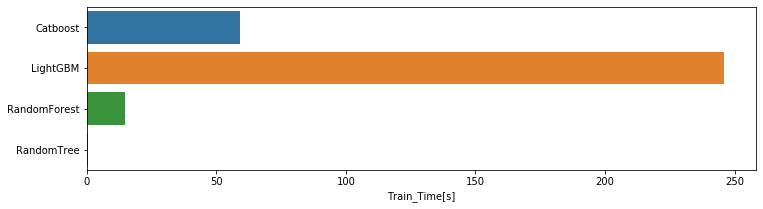

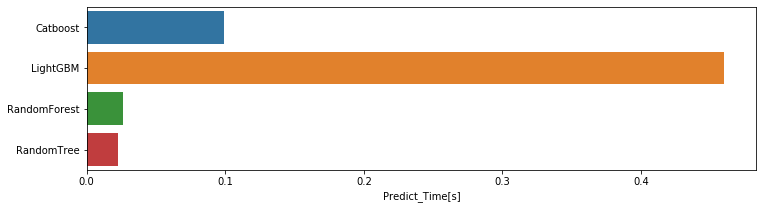

In [34]:
for col in columns[3:]:
    plt.figure(figsize=(12, 3))
    sns.barplot(y=index, x=col, data=final)
    plt.show()

Наибольшее время обучения у модели градиентного бустинга LGBM, что связано с высокой ресурсоёмкостью. Catboost и случайный лес обучаются значительно быстрее, в то время как решающее дерево - практически мгновенно. Скорость предсказания у моделей случайного леса и дерева максимальная, Кэтбуст примерно в 3-4  раза медленее, LGBM предсказывает результат на порядок дольше - несколько секунд.

## Заключение

Таким образом, если приоритет Заказчика - качество предсказания, то стоит обратить внимание на модели с алгоритмами LightGBM и Catboost. Если важен баланс между качеством/скоростью предсказаний - выбираем модель случайного леса. Если же приоритет быстродействие, то можно остановить свой выбор на модели решающего дерева.